<a href="https://colab.research.google.com/github/lisaong/hss/blob/colab/05_physionet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensor Data Analysis

### Tasks

Analyse "Bag of sensors" data from PhysioNet: https://physionet.org/physiobank/database/noneeg/

Under/Oversampling

Feature Extraction
- Statistical
- Spectral

Machine Learning

## Data Introduction

This database contains non-EEG physiological signals collected at Quality of Life Laboratory at University of Texas at Dallas, used to infer the neurological status (including physical stress, cognitive stress, emotional stress and relaxation) of 20 healthy subjects. The data was collected using non-invasive wrist worn biosensors and consists of electrodermal activity (EDA), temperature, acceleration, heart rate (HR), and arterial oxygen level (SpO2).

The experimental procedures involving human subjects described in this work were approved under UTD IRB # 12-29 by the Institutional Review Board at the University of Texas at Dallas, Richardson, Texas, USA. 

The dataset consists of 7 stages for 20 subjects: 

- First Relaxation: five minutes 
- Physical Stress: Stand for one minute, walk on a treadmill at one mile per hour for two minutes, then walk/jog on the treadmill at three miles per hour for two minutes. 
- Second Relaxation: five minutes
- Mini-emotional stress: 40 seconds (Note: This portion of the data, which was collected right before the cognitive stress task, is not explained in the paper.) During this 40 seconds, the “instructions” for the math portion of the cognitive stress (to count backwards by sevens, beginning with 2485, for three minutes) were read to the volunteer. 
- Cognitive Stress: Count backwards by sevens, beginning with 2485, for three minutes. Next, perform the Stroop test for two minutes. The volunteer was alerted to errors by a buzzer. The Stroop test consisted of reading the names of colors written in a different color ink, then saying what color the ink was. 
- Third Relaxation: five minutes. 
- Emotional Stress: The volunteer was told he/she would be shown a five minute clip from a horror movie in one minute. After the minute of anticipation, a clip from a zombie apocalypse movie, The Horde was shown. 
- Fourth Relaxation: five minutes. 

Note: We had not originally intended to count the reading of the instructions to count backwards as an emotional stress. After all, instructions were given for each of the tasks. Unlike the other instruction sets, however, this one created a stress response in many of the volunteers that was obvious to the test administrator as the test was being given.

## Load Data

Each subject has several datafiles:
- SubjectN_AccTempEDA.atr: annotation
- SubjectN_AccTempEDA.dat: data
- SubjectN_AccTempEDA.hea: header
- SubjectN_Sp02HR.dat: data
- SubjectN_Sp02HR.hea: header

These files are in the WFDB (WaveForm DataBase) format, and can be read using the `wfdb` python module.
(https://github.com/MIT-LCP/wfdb-python)

https://www.physionet.org/standards/npsg/Moody.pdf

In [157]:
# Download and extract the data files
!wget -q -O Subject10.zip https://github.com/lisaong/hss/raw/colab/data/physionet/Subject10.zip
!unzip -o Subject10.zip
!rm Subject10.zip

Archive:  Subject10.zip
  inflating: Subject10_AccTempEDA.atr  
  inflating: Subject10_AccTempEDA.dat  
  inflating: Subject10_AccTempEDA.hea  
  inflating: Subject10_SpO2HR.dat    
  inflating: Subject10_SpO2HR.hea    


In [158]:
# Install the Waveform Database library to read the data files
!pip install wfdb

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from scipy import fftpack, signal

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA

sns.set_style('whitegrid') # style

import wfdb

# render plots inline
%matplotlib inline

### Acc Temp EDA

Accelerometer, Temperature, Electrodermal Activity Data

In [160]:
# Read annotations
ann = wfdb.rdann('./Subject10_AccTempEDA', extension='atr', summarize_labels=True)
print(ann.__dict__)

{'record_name': 'Subject10_AccTempEDA', 'extension': 'atr', 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]), 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"'], 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]), 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]), 'num': array([0, 0, 0, 0, 0, 0, 0, 0]), 'aux_note': ['Relax', 'PhysicalStress', 'Relax', 'EmotionalStress', 'CognitiveStress', 'Relax', 'EmotionalStress', 'Relax'], 'fs': 8, 'label_store': None, 'description': None, 'custom_labels': None, 'contained_labels':     label_store symbol         description
22           22      "  Comment annotation, 'ann_len': 8}


{'record_name': 'Subject10_AccTempEDA', 'n_sig': 5, 'fs': 8, 'counter_freq': None, 'base_counter': None, 'sig_len': 18239, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['ax', 'ay', 'az', 'temp', 'EDA'], 'p_signal': array([[ 4.49967956e-01, -1.00996857e+00, -4.00036622e-02,
         2.70000641e+01,  3.25101413e+00],
       [ 4.39992676e-01, -1.01998718e+00, -4.00036622e-02,
         2.70000641e+01,  3.25605237e+00],
       [ 4.49967956e-01, -1.01998718e+00, -5.00045778e-02,
         2.70000641e+01,  3.25605237e+00],
       ...,
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00],
       [ 8.79985351e-01, -7.49980163e-01, -2.00018311e-02,
         3.34999664e+01,  6.22591473e+00]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject1

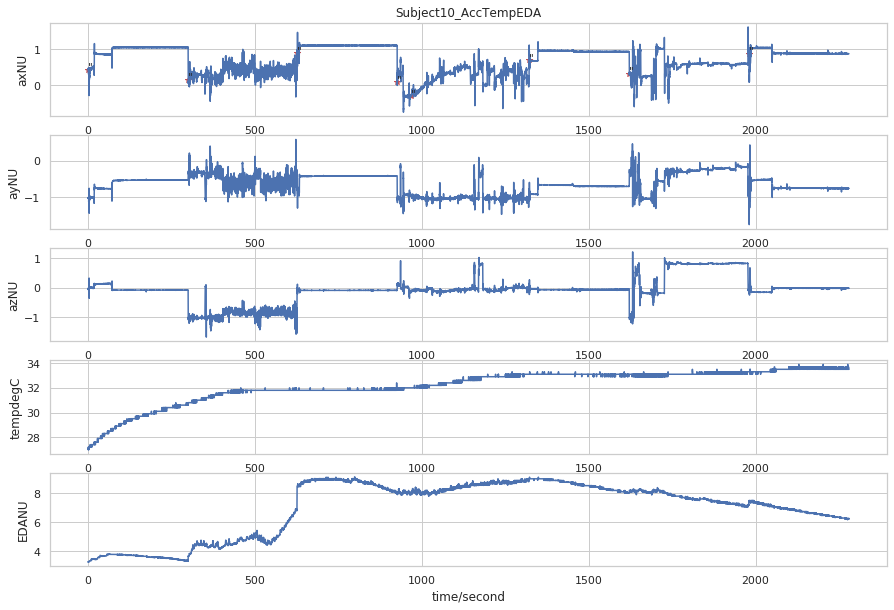

In [161]:
# Read records
record_acc_temp_eda = wfdb.rdrecord('./Subject10_AccTempEDA')
print(record_acc_temp_eda.__dict__)

wfdb.plot_wfdb(record=record_acc_temp_eda, title='Subject10_AccTempEDA', annotation=ann, plot_sym=True, 
               time_units='seconds', figsize=(15, 10))

In [162]:
data_acc_temp_eda = record_acc_temp_eda.p_signal
data_acc_temp_eda.shape

(18239, 5)

### SpO2 HR

Arterial Oxygen Levels, Heartrate


{'record_name': 'Subject10_SpO2HR', 'n_sig': 2, 'fs': 1, 'counter_freq': None, 'base_counter': None, 'sig_len': 2286, 'base_time': None, 'base_date': None, 'comments': ['age: 23', 'gender: M', 'height/cm: 180', 'weight/kg: 64'], 'sig_name': ['SpO2', 'hr'], 'p_signal': array([[96.99995422, 95.99990844],
       [95.99993896, 95.99990844],
       [95.99993896, 96.9999237 ],
       ...,
       [95.99993896, 69.00027467],
       [95.99993896, 68.00025941],
       [95.99993896, 67.00024415]]), 'd_signal': None, 'e_p_signal': None, 'e_d_signal': None, 'file_name': ['Subject10_SpO2HR.dat', 'Subject10_SpO2HR.dat'], 'fmt': ['16', '16'], 'samps_per_frame': [1, 1], 'skew': [None, None], 'byte_offset': [None, None], 'adc_gain': [13106.8, 1284.98039216], 'baseline': [-1251699, -112435], 'units': ['%', 'bpm'], 'adc_res': [16, 16], 'adc_zero': [0, 0], 'init_value': [19660, 10923], 'checksum': [39424, 34156], 'block_size': [0, 0]}


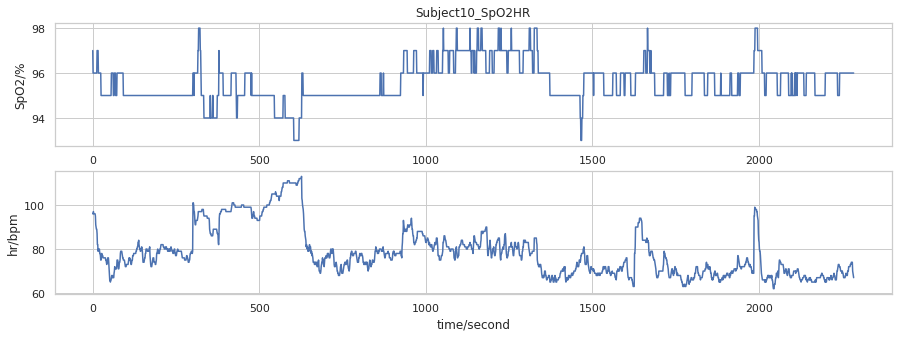

In [163]:
record_spo2_hr = wfdb.rdrecord('./Subject10_SpO2HR')
print(record_spo2_hr.__dict__)

wfdb.plot_wfdb(record=record_spo2_hr, title='Subject10_SpO2HR', time_units='seconds', figsize=(15, 5))

In [164]:
data_spo2_hr = record_spo2_hr.p_signal
data_spo2_hr.shape

(2286, 2)

In [165]:
# number of acceleration, etc samples per second
record_acc_temp_eda.fs

8

In [166]:
# number of SpO2 and HR samples per second
record_spo2_hr.fs

1

## Aligning data of different frequencies

The two dataset frequencies (number of samples per second) are different.

To support processing both datasets at the same time, we need to match the frequencies.

This is a common situation when taking readings from different sensors or data sources.

Two strategies:
1. Upsampling the smaller frequency data. E.g: repeat samples or interpolate.
2. Downsampling the larger frequency data. E.g: replace with mean or median.

Which one to pick depends on requirements: whether you need to maintain precision of the higher frequency dataset.

Example: https://machinelearningmastery.com/resample-interpolate-time-series-data-python/

### Option 1: Upsampling SpO2 HR to 8 samples per second

This option duplicates the SpO2 HR data at the smaller sampling interval.

In [167]:
# create an index with 1 second timestamps, using the length of data_spo2_hr
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.period_range.html
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference so that we can
# use resample()
per_second_index = pd.period_range(start='2019-01-01', periods=len(data_spo2_hr), freq='S')
per_second_index

PeriodIndex(['2019-01-01 00:00:00', '2019-01-01 00:00:01',
             '2019-01-01 00:00:02', '2019-01-01 00:00:03',
             '2019-01-01 00:00:04', '2019-01-01 00:00:05',
             '2019-01-01 00:00:06', '2019-01-01 00:00:07',
             '2019-01-01 00:00:08', '2019-01-01 00:00:09',
             ...
             '2019-01-01 00:37:56', '2019-01-01 00:37:57',
             '2019-01-01 00:37:58', '2019-01-01 00:37:59',
             '2019-01-01 00:38:00', '2019-01-01 00:38:01',
             '2019-01-01 00:38:02', '2019-01-01 00:38:03',
             '2019-01-01 00:38:04', '2019-01-01 00:38:05'],
            dtype='period[S]', length=2286, freq='S')

In [168]:
# create a dataframe for SpO2 data using the above period index
df_spO2_hr = pd.DataFrame(data_spo2_hr, index=per_second_index, columns=record_spo2_hr.sig_name)
df_spO2_hr.head()

,SpO2,hr
2019-01-01 00:00:00,96.999954,95.999908
2019-01-01 00:00:01,95.999939,95.999908
2019-01-01 00:00:02,95.999939,96.999924
2019-01-01 00:00:03,95.999939,95.999908
2019-01-01 00:00:04,95.999939,95.999908


In [169]:
# upsample to match the frequency of the other data (8 times)

samples_per_sec = record_acc_temp_eda.fs // record_spo2_hr.fs # // converts float to int (ceiling)
samples_per_sec

8

In [170]:
# resample, then interpolate
# Note: whether interpolation makes sense depends on the sensor and use case
upsampled = df_spO2_hr.resample('125ms')

df_upsampled = upsampled.interpolate()
df_upsampled.head(10)

,SpO2,hr
2019-01-01 00:00:00.000,96.999954,95.999908
2019-01-01 00:00:00.125,96.874952,95.999908
2019-01-01 00:00:00.250,96.749950,95.999908
2019-01-01 00:00:00.375,96.624949,95.999908
2019-01-01 00:00:00.500,96.499947,95.999908
2019-01-01 00:00:00.625,96.374945,95.999908
2019-01-01 00:00:00.750,96.249943,95.999908
2019-01-01 00:00:00.875,96.124941,95.999908
2019-01-01 00:00:01.000,95.999939,95.999908
2019-01-01 00:00:01.125,95.999939,96.124910


In [171]:
# inspect the resulting dataframe
# Note the number of rows has increased by a factor of 8
df_upsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18288 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:38:05.875
Freq: 125L
Data columns (total 2 columns):
SpO2    18288 non-null float64
hr      18288 non-null float64
dtypes: float64(2)
memory usage: 428.6 KB


In [172]:
# Note: there are fewer values in the Acc dataframe, so we need to ignore the
# later entries from df_upsampled.

df_acc_temp_eda = pd.DataFrame(data_acc_temp_eda, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18239 entries, 0 to 18238
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 712.6 KB


In [173]:
# skip the first (18288-18239 = 49) entries
df_acc_temp_eda.index = df_upsampled.index[:len(df_acc_temp_eda)]
df_acc_temp_eda.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 5 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
dtypes: float64(5)
memory usage: 855.0 KB


In [174]:
# concatenate the two dataframes, column-wise
# we now have Acc, Temp, EDA, SpO2, HR in 1 combined dataframe
df_option1 = pd.concat([df_acc_temp_eda, df_upsampled], axis=1).dropna()
df_option1.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908


In [175]:
# inspect the number of columns, rows, and datatype
df_option1.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 18239 entries, 2019-01-01 00:00:00.000 to 2019-01-01 00:37:59.750
Freq: 125L
Data columns (total 7 columns):
ax      18239 non-null float64
ay      18239 non-null float64
az      18239 non-null float64
temp    18239 non-null float64
EDA     18239 non-null float64
SpO2    18239 non-null float64
hr      18239 non-null float64
dtypes: float64(7)
memory usage: 1.1 MB


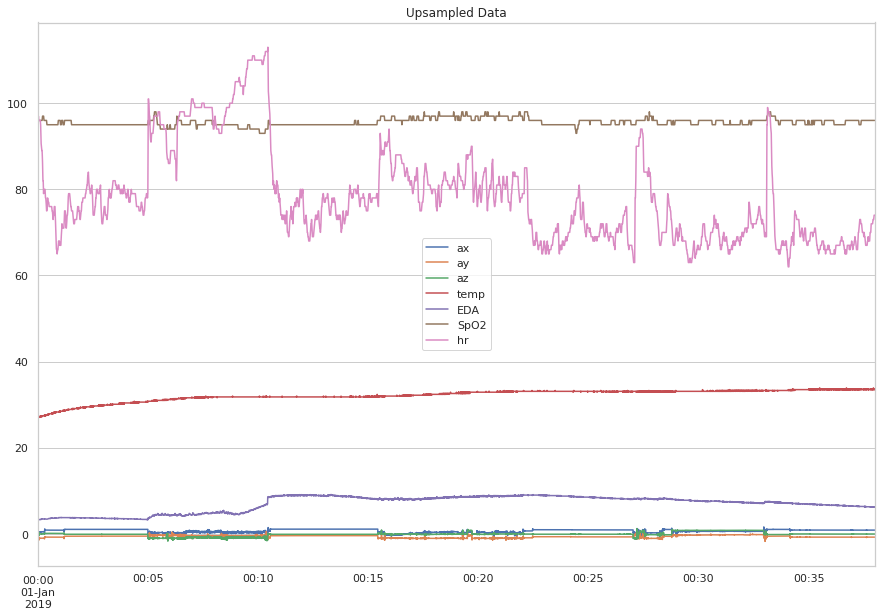

In [176]:
# Plot the data
# https://stackoverflow.com/questions/48126330/python-int-too-large-to-convert-to-c-long-plotting-pandas-dates
df_option1.index = pd.to_datetime(df_option1.index.to_timestamp())

df_option1.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Upsampled Data')
plt.show()

### Option 2: Downsampling Acc Temp EDA to 1 sample per second

In the previous option, we duplicate SpO2 HR data to the smaller interval. 

**What problems do you think this causes?**

An alternative approach is to sample the Acc Temp EDA data to match the larger interval of SpO2 HR.


In [177]:
# create an index with 125 millisecond timestamps, using the length of data_acc_temp_eda
#
# frequency strings: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

# for this dataset, the start date is just an arbitrary reference
per_125_ms_index = pd.period_range(start='2019-01-01', periods=len(data_acc_temp_eda), freq='125ms')
per_125_ms_index

PeriodIndex(['2019-01-01 00:00:00.000', '2019-01-01 00:00:00.125',
             '2019-01-01 00:00:00.250', '2019-01-01 00:00:00.375',
             '2019-01-01 00:00:00.500', '2019-01-01 00:00:00.625',
             '2019-01-01 00:00:00.750', '2019-01-01 00:00:00.875',
             '2019-01-01 00:00:01.000', '2019-01-01 00:00:01.125',
             ...
             '2019-01-01 00:37:58.625', '2019-01-01 00:37:58.750',
             '2019-01-01 00:37:58.875', '2019-01-01 00:37:59.000',
             '2019-01-01 00:37:59.125', '2019-01-01 00:37:59.250',
             '2019-01-01 00:37:59.375', '2019-01-01 00:37:59.500',
             '2019-01-01 00:37:59.625', '2019-01-01 00:37:59.750'],
            dtype='period[125L]', length=18239, freq='125L')

In [178]:
# create a dataframe for Acc Temp EDA using the 125ms period index
df_acc_temp_eda2 = pd.DataFrame(data_acc_temp_eda, index=per_125_ms_index, columns=record_acc_temp_eda.sig_name)
df_acc_temp_eda2.head()

,ax,ay,az,temp,EDA
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052


In [179]:
# downsample using median of Acc Temp EDA2
# using median is safer than using mean because median is less susceptible to outliers
# Can you think of the reason why median is less susceptible to outliers?

df_acc_temp_eda_downsampled = df_acc_temp_eda2.resample('S').median()
df_acc_temp_eda_downsampled.head(10)

,ax,ay,az,temp,EDA
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034
2019-01-01 00:00:05,0.419988,-1.009969,0.004978,27.200008,3.336034
2019-01-01 00:00:06,0.459979,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:07,0.479966,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:08,0.489977,-0.999985,0.000000,27.200008,3.342062
2019-01-01 00:00:09,0.489977,-0.999985,0.000000,27.200008,3.395054


In [180]:
# inspected the downsampled data
# Note the resulting number of rows has decreased by a factor of 8
df_acc_temp_eda_downsampled.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 5 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
dtypes: float64(5)
memory usage: 106.9 KB


In [181]:
# create a dataframe so that we can concatenate
df_spo2_hr2 = pd.DataFrame(data_spo2_hr, columns=record_spo2_hr.sig_name, index=per_second_index)
df_spo2_hr2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2286 entries, 2019-01-01 00:00:00 to 2019-01-01 00:38:05
Freq: S
Data columns (total 2 columns):
SpO2    2286 non-null float64
hr      2286 non-null float64
dtypes: float64(2)
memory usage: 53.6 KB


In [182]:
# concatenate the two dataframes, column-wise
df_option2 = pd.concat([df_acc_temp_eda_downsampled, df_spo2_hr2], axis=1).dropna()
df_option2.head()

,ax,ay,az,temp,EDA,SpO2,hr
2019-01-01 00:00:00,0.449968,-1.009969,-0.045004,27.000064,3.256052,96.999954,95.999908
2019-01-01 00:00:01,0.439993,-1.009969,-0.040004,27.200008,3.256052,95.999939,95.999908
2019-01-01 00:00:02,0.385021,-1.034980,0.144969,27.200008,3.267568,95.999939,96.999924
2019-01-01 00:00:03,-0.154977,-0.984975,0.104965,27.200008,3.279084,95.999939,95.999908
2019-01-01 00:00:04,0.215027,-1.039989,0.009957,27.200008,3.336034,95.999939,95.999908


In [183]:
# inspect the resulting dataframe of Acc Temp EDA SpO2 HR data
df_option2.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 2280 entries, 2019-01-01 00:00:00 to 2019-01-01 00:37:59
Freq: S
Data columns (total 7 columns):
ax      2280 non-null float64
ay      2280 non-null float64
az      2280 non-null float64
temp    2280 non-null float64
EDA     2280 non-null float64
SpO2    2280 non-null float64
hr      2280 non-null float64
dtypes: float64(7)
memory usage: 142.5 KB


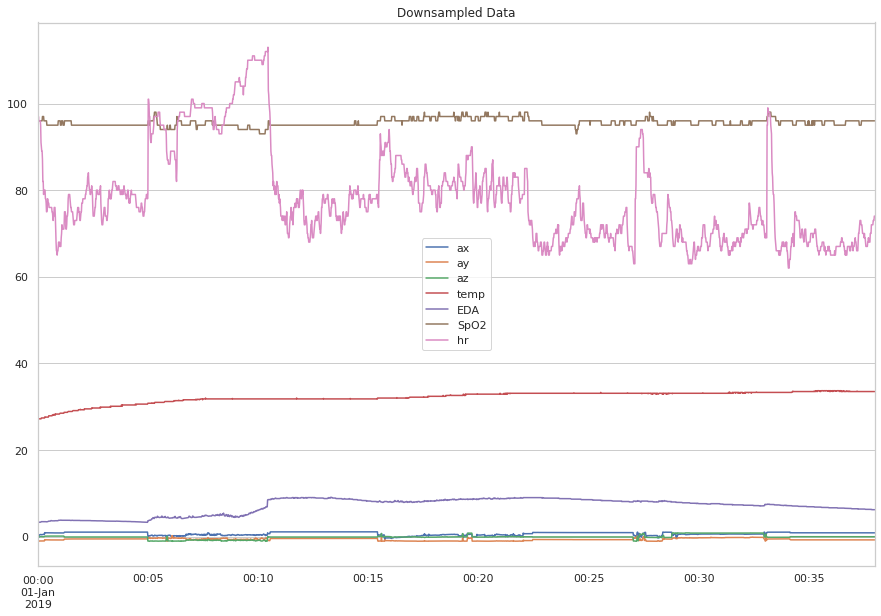

In [184]:
# plot the data
df_option2.index = pd.to_datetime(df_option2.index.to_timestamp())

df_option2.plot(figsize=(15, 10))
ax = plt.gca()
ax.set_title('Downsampled Data')
plt.show()

Comparison of approaches
- Plot the two datasets (upsampled vs downsampled) side-by-side
- **Do you observe any differences?** 

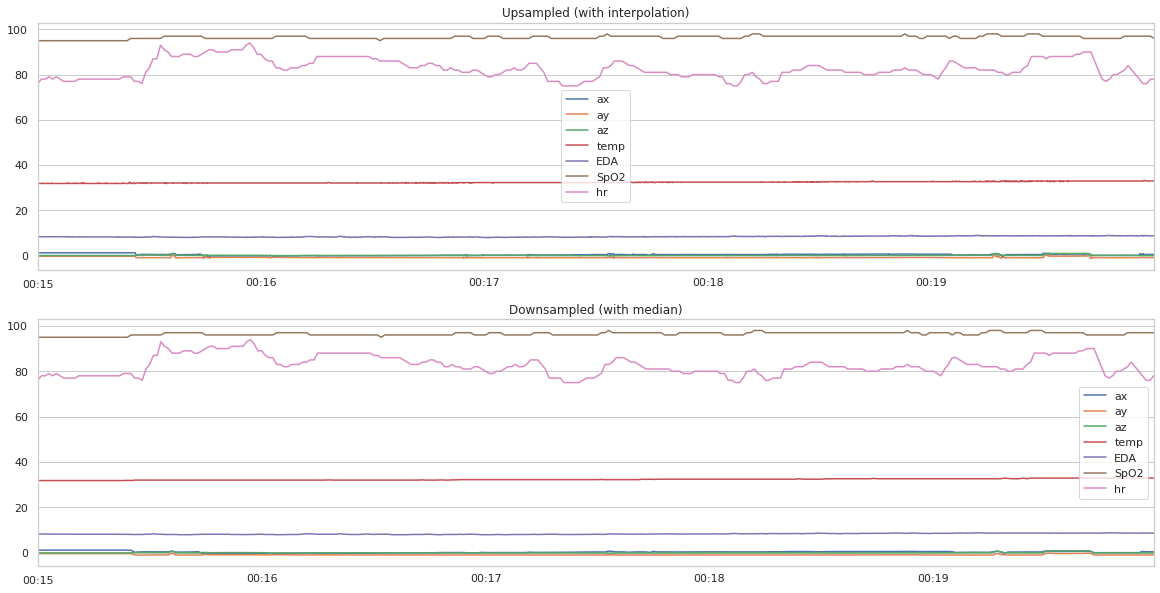

In [185]:
# Let's zoom into a 5-second time window and compare the plots

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
start_time = '2019-01-01 00:15'
end_time = '2019-01-01 00:20'

df_option1[(df_option1.index >= start_time) & (df_option1.index < end_time)].plot(ax=ax1)
ax1.set_title('Upsampled (with interpolation)')
df_option2[(df_option2.index >= start_time) & (df_option2.index < end_time)].plot(ax=ax2)
ax2.set_title('Downsampled (with median)')
plt.show()

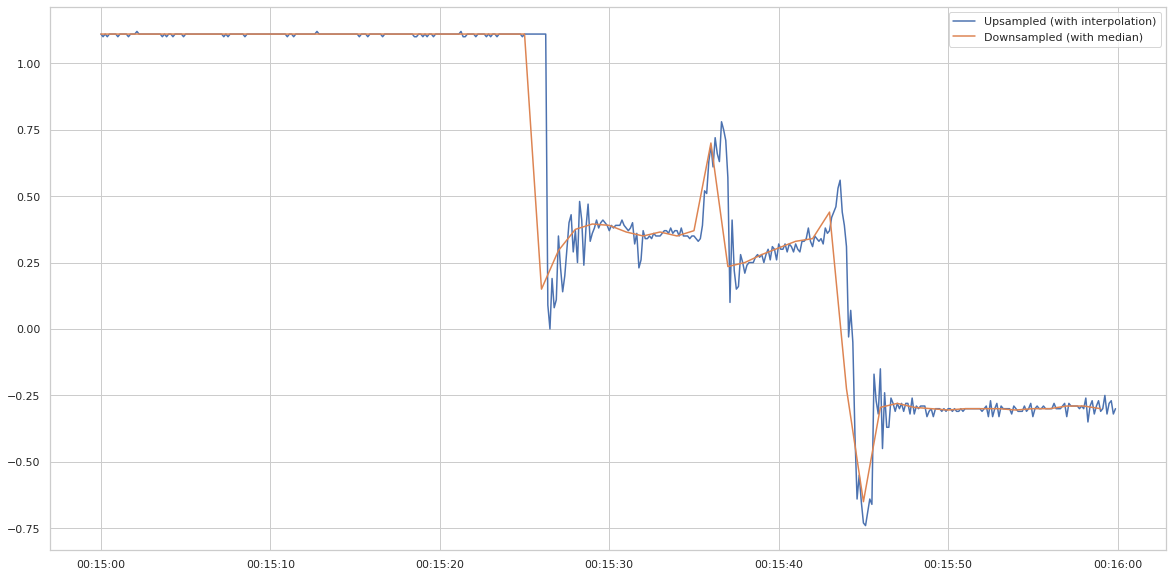

In [186]:
# Let's plot accelerometerX side-by-side

fig, ax = plt.subplots(figsize=(20, 10))
start_time = '2019-01-01 00:15'
end_time = '2019-01-01 00:16'

column = 'ax'

ax.plot(df_option1[(df_option1.index >= start_time) & (df_option1.index < end_time)][column],
        label='Upsampled (with interpolation)')
ax.plot(df_option2[(df_option2.index >= start_time) & (df_option2.index < end_time)][column],
        label='Downsampled (with median)')
ax.legend()
plt.show()

Repeat the above for Ay, etc. 

**What do you observe if you compare the upsampled/downsampled SpO2 or HR? Why?**

## Statistical Features

Basic statistical features you can get from time-series data, using Pandas and other python libraries:

- Mean, median, standard deviation
- Quantisation / discretisation
- Correlation
- Auto-correlation

In [0]:
df = df_option1.copy()

In [188]:
df.mean() # mean of each column

ax       0.692899
ay      -0.624442
az      -0.079151
temp    32.179924
EDA      7.020280
SpO2    95.587481
hr      78.470389
dtype: float64

In [189]:
df.median() # median is less sensitive to outliers than mean

ax       0.869974
ay      -0.639988
az      -0.080007
temp    32.599957
EDA      7.809991
SpO2    95.249985
hr      76.125383
dtype: float64

In [190]:
df.std() # standard deviation

ax       0.365214
ay       0.259942
az       0.451252
temp     1.336794
EDA      1.876670
SpO2     0.855413
hr      11.066407
dtype: float64

In [191]:
df.max()

ax        1.619993
ay        0.579982
az        1.219979
temp     33.899959
EDA       9.146924
SpO2     97.999969
hr      112.999390
dtype: float64

In [192]:
df.min()

ax      -0.739971
ay      -1.739982
az      -1.679977
temp    27.000064
EDA      3.251014
SpO2    93.000046
hr      62.000168
dtype: float64

### Discretise into quantiles

Another technique with Time Series data is to apply Discretisation.  Discretisation is useful when there is a lot of noise in the signal and you want to create models that work more generically (on "bins" of input values).

https://datascience.stackexchange.com/questions/19782/what-is-the-rationale-for-discretization-of-continuous-features-and-when-should

In [193]:
df.ax.values.ravel() # raw values

array([0.44996796, 0.43999268, 0.44996796, ..., 0.87998535, 0.87998535,
       0.87998535])

In [194]:
# discretise using qcut, 10 bins
# duplicates='drop' drops overlapping edges
df['ax_q10'] = pd.qcut(df.ax.values.ravel(), 10, duplicates='drop')
df.ax_q10.value_counts()

(0.89, 0.96]      2110
(0.49, 0.6]       2027
(0.19, 0.34]      1922
(-0.741, 0.19]    1843
(0.87, 0.89]      1771
(0.34, 0.49]      1770
(1.05, 1.1]       1745
(1.1, 1.62]       1711
(0.96, 1.05]      1674
(0.6, 0.87]       1666
Name: ax_q10, dtype: int64

In [195]:
df['ax_q10']

2019-01-01 00:00:00.000    (0.34, 0.49]
2019-01-01 00:00:00.125    (0.34, 0.49]
2019-01-01 00:00:00.250    (0.34, 0.49]
2019-01-01 00:00:00.375    (0.34, 0.49]
2019-01-01 00:00:00.500    (0.34, 0.49]
                               ...     
2019-01-01 00:37:59.250    (0.87, 0.89]
2019-01-01 00:37:59.375    (0.87, 0.89]
2019-01-01 00:37:59.500    (0.87, 0.89]
2019-01-01 00:37:59.625    (0.87, 0.89]
2019-01-01 00:37:59.750    (0.87, 0.89]
Freq: 125L, Name: ax_q10, Length: 18239, dtype: category
Categories (10, interval[float64]): [(-0.741, 0.19] < (0.19, 0.34] < (0.34, 0.49] < (0.49, 0.6] < ... <
                                     (0.89, 0.96] < (0.96, 1.05] < (1.05, 1.1] < (1.1, 1.62]]

In [0]:
df['ay_q10'] = pd.qcut(df.ay.values.ravel(), 10, duplicates='drop')
df['az_q10'] = pd.qcut(df.az.values.ravel(), 10, duplicates='drop')

In [197]:
df.ay_q10.value_counts()

(-0.53, -0.42]                  2505
(-0.75, -0.69]                  2242
(-1.7409999999999999, -1.02]    2091
(-0.64, -0.53]                  2070
(-0.91, -0.75]                  1988
(-0.28, 0.58]                   1768
(-1.02, -0.91]                  1703
(-0.41, -0.28]                  1363
(-0.42, -0.41]                  1363
(-0.69, -0.64]                  1146
Name: ay_q10, dtype: int64

In [198]:
df.az_q10.value_counts()

(-0.15, -0.09]                  3409
(-0.07, -0.02]                  2530
(-0.09, -0.08]                  2087
(-0.84, -0.15]                  1881
(-1.6809999999999998, -0.84]    1853
(0.8, 1.22]                     1786
(-0.08, -0.07]                  1735
(-0.02, 0.0]                    1547
(0.0, 0.8]                      1411
Name: az_q10, dtype: int64

### Pair-plot

Pair plots are a combination of scatter plots and histograms. 

They are done for each pair of features (e.g. ax vs. ay)

https://seaborn.pydata.org/generated/seaborn.pairplot.html

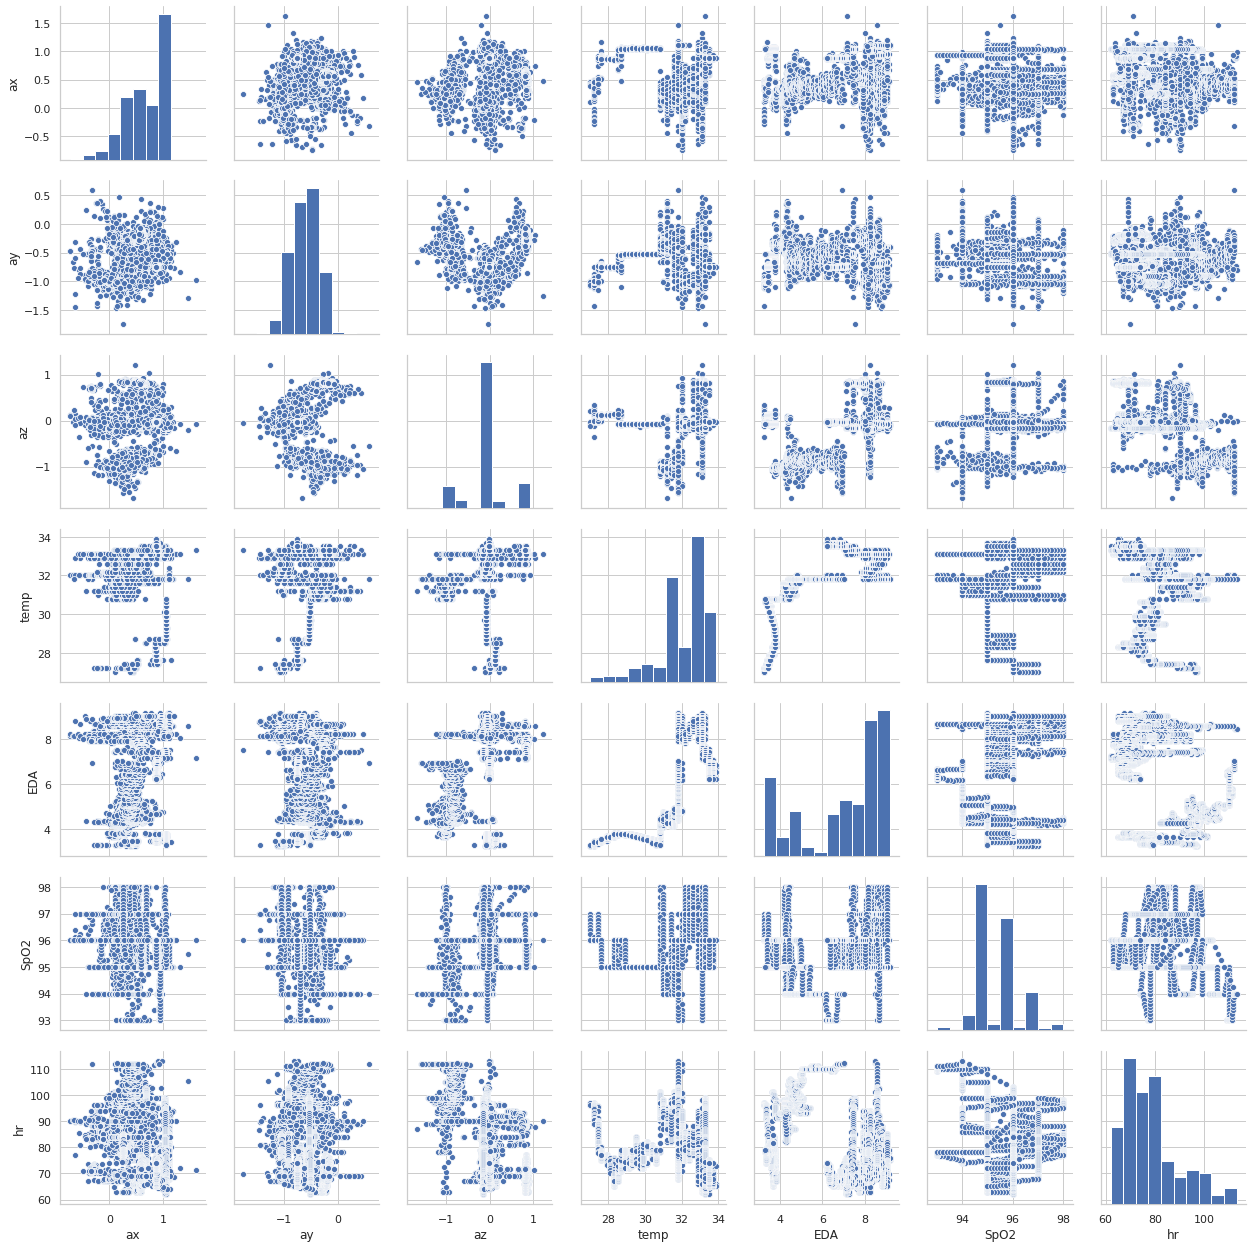

In [199]:
sns.pairplot(df)
plt.show()

1. What do you notice about temp vs. EDA? **Are they positively or negatively correlated?**
2. Do you notice any **outliers** in the data? If yes, can you think of a simple way to remove outliers? (hint: something that uses the simple statistical features)


### Correlation

Correlations provide a metric to indicate whether two variables are strongly dependent.

https://www.statisticssolutions.com/correlation-pearson-kendall-spearman/

In [200]:
df.corr(method='pearson')

,ax,ay,az,temp,EDA,SpO2,hr
ax,1.000000,0.362244,0.170707,-0.110856,-0.018944,-0.298530,-0.473594
ay,0.362244,1.000000,0.159515,-0.077881,-0.186343,-0.479444,-0.081967
az,0.170707,0.159515,1.000000,0.264251,0.352114,0.246086,-0.661918
temp,-0.110856,-0.077881,0.264251,1.000000,0.695196,0.275015,-0.311503
EDA,-0.018944,-0.186343,0.352114,0.695196,1.000000,0.324747,-0.344800
SpO2,-0.298530,-0.479444,0.246086,0.275015,0.324747,1.000000,-0.113245
hr,-0.473594,-0.081967,-0.661918,-0.311503,-0.344800,-0.113245,1.000000


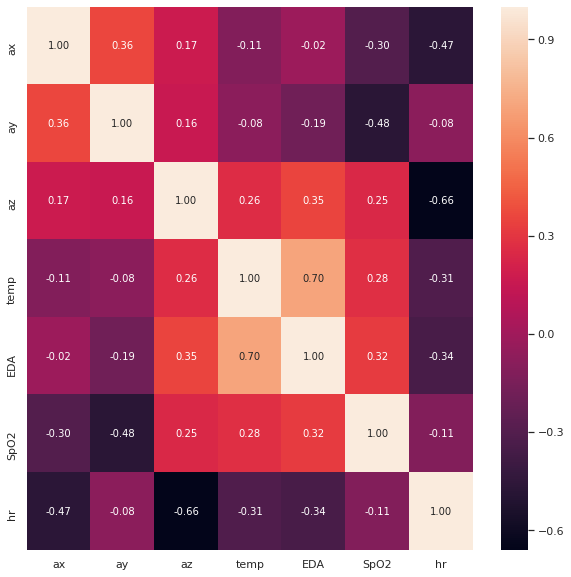

In [201]:
# a graphical way to viewing the correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df.corr(method='pearson'), annot=True, fmt='.2f')
plt.show()

## Spectal Features

Another way to extract features from time series data is to decompose the time series into its frequency components.

A common technique is to use Fast Fourier Transforms:

https://flothesof.github.io/Fourier-series-rectangle.html

https://ipython-books.github.io/101-analyzing-the-frequency-components-of-a-signal-with-a-fast-fourier-transform/

In [0]:
# Helper function to compute power spectral density
def power_spectral_density(x):
    psd = np.abs(x) ** 2
    return 20 * np.log10(psd / psd.max()) # decibels

In [0]:
# Compute fft of some signals
fft_ax = fftpack.fft(df.ax)
fft_hr = fftpack.fft(df.hr)
fft_eda = fftpack.fft(df.EDA)
# can add other signals as well

# Extract the power spectral density (squared magnitude of FFT, in decibels)
psd_ax = power_spectral_density(fft_ax)
psd_hr = power_spectral_density(fft_hr)
psd_eda = power_spectral_density(fft_eda)

sample_freq = fftpack.fftfreq(len(df.ax), d=1./samples_per_sec)

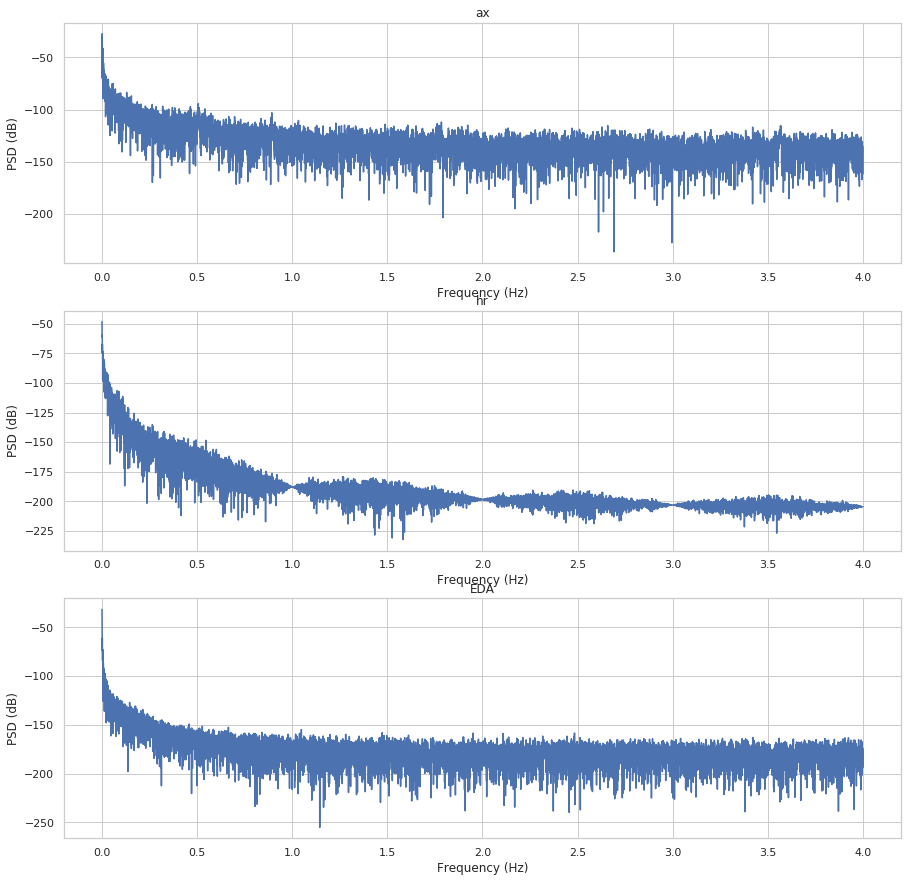

In [204]:
# plot the PSD of each FFT, focusing only on the positive frequencies
pos_mask = sample_freq > 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1.plot(sample_freq[pos_mask], psd_ax[pos_mask])
ax1.set_title('ax')
ax1.set_ylabel('PSD (dB)')
ax1.set_xlabel('Frequency (Hz)')

ax2.plot(sample_freq[pos_mask], psd_hr[pos_mask])
ax2.set_title('hr')
ax2.set_ylabel('PSD (dB)')
ax2.set_xlabel('Frequency (Hz)')

ax3.plot(sample_freq[pos_mask], psd_eda[pos_mask])
ax3.set_title('EDA')
ax3.set_ylabel('PSD (dB)')
ax3.set_xlabel('Frequency (Hz)')

plt.show()

### Smoothing

The above FFTs are very noisy, because we are reading individual samples.

Let's try to apply a window technique to smooth out the samples.

An example is Hamming Window:
https://flothesof.github.io/FFT-window-properties-frequency-analysis.html

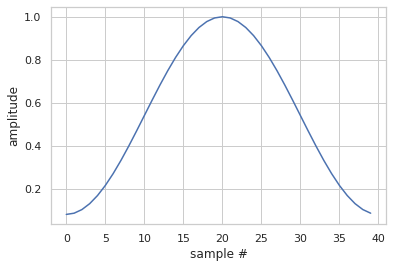

In [205]:
m = samples_per_sec * 5 # window size
w = signal.get_window('hamming', m)

fig, ax = plt.subplots()
ax.plot(w)
ax.set_xlabel('sample #')
ax.set_ylabel('amplitude')
plt.show()

The above is a hamming window of 5 seconds (8 samples per second).

Now, let's apply the windowing function to our signals, and then take the FFT.


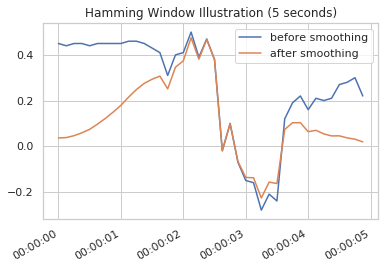

In [206]:
# transform the signal into windows
smoothed_window = df.ax[:m] * w

fig, ax = plt.subplots()
ax.plot(df.ax[:m], label='before smoothing')
ax.plot(smoothed_window, label='after smoothing')
ax.legend()
ax.set_title('Hamming Window Illustration (5 seconds)')
fig.autofmt_xdate()

plt.show()

**What do you observe?**

For example, look at the Hamming Window function and try to get an intuition of what "after smoothing" is, compared to "before smoothing." 

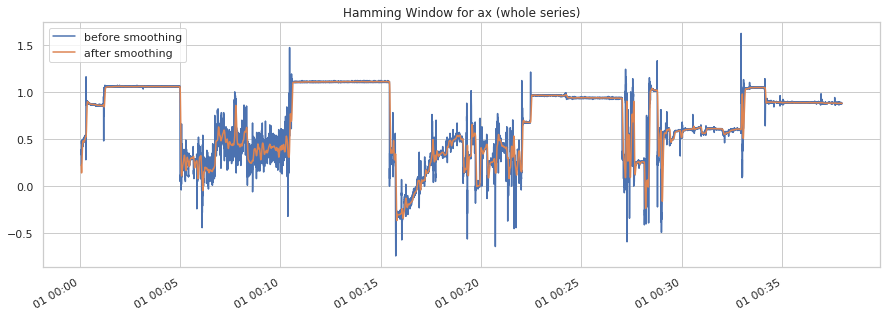

In [207]:
# Apply a rolling window transform onto the whole signal
df_smoothed = df.rolling(m, win_type='hamming').mean().dropna()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df.ax[m-1:], label='before smoothing')
ax.plot(df_smoothed.ax, label='after smoothing')
ax.set_title('Hamming Window for ax (whole series)')

fig.autofmt_xdate()
ax.legend()
plt.show()

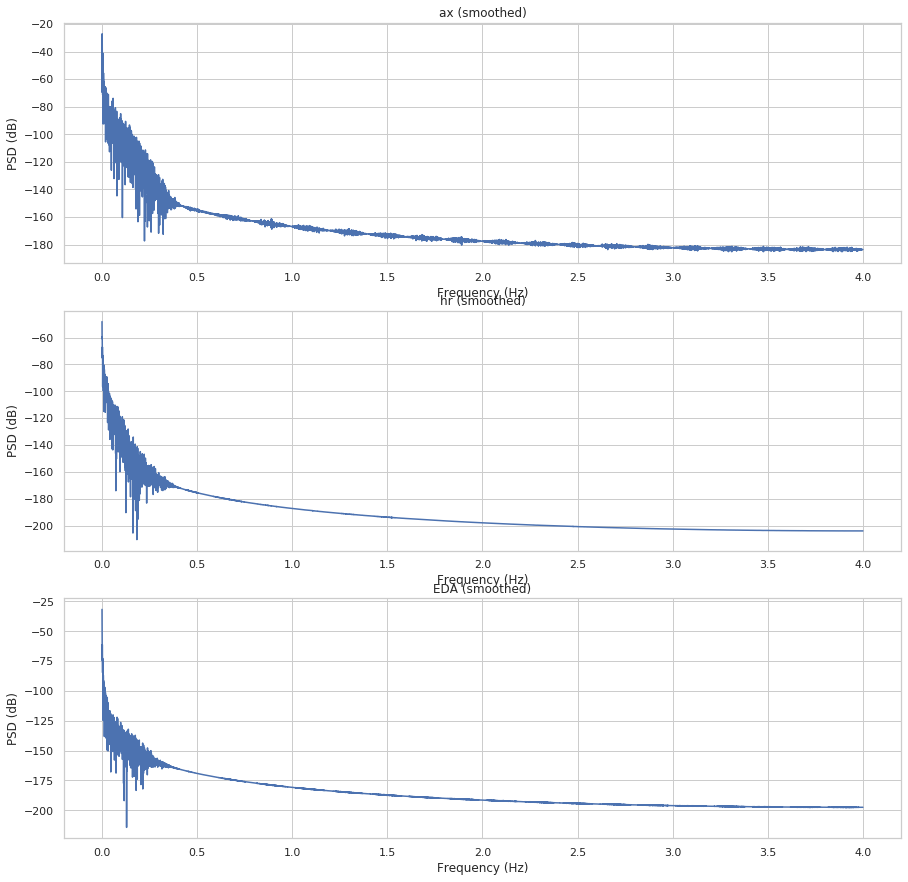

In [208]:
# Recompute FFT on the smoothed signals

fft_ax = fftpack.fft(df_smoothed.ax)
fft_hr = fftpack.fft(df_smoothed.hr)
fft_eda = fftpack.fft(df_smoothed.EDA)

psd_ax = power_spectral_density(fft_ax)
psd_hr = power_spectral_density(fft_hr)
psd_eda = power_spectral_density(fft_eda)

sample_freq = fftpack.fftfreq(len(df_smoothed.ax), d=1./samples_per_sec)

pos_mask = sample_freq > 0

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(15, 15))

ax1.plot(sample_freq[pos_mask], psd_ax[pos_mask])
ax1.set_title('ax (smoothed)')
ax1.set_ylabel('PSD (dB)')
ax1.set_xlabel('Frequency (Hz)')

ax2.plot(sample_freq[pos_mask], psd_hr[pos_mask])
ax2.set_title('hr (smoothed)')
ax2.set_ylabel('PSD (dB)')
ax2.set_xlabel('Frequency (Hz)')

ax3.plot(sample_freq[pos_mask], psd_eda[pos_mask])
ax3.set_title('EDA (smoothed)')
ax3.set_ylabel('PSD (dB)')
ax3.set_xlabel('Frequency (Hz)')

plt.show()

## Machine Learning

In the next section, we can explore machine learning using first the time domain signal (with discretised features), and then later on using the frequency-domain features.

- Encode discretised features
- Add and encode labels
- Train an "emotional state" classification model
  - Classification using time-domain signal
  - Classification using frequency-domain features

### Encode discretised features

To add the discretised features, we can map the bins to categorical values.

In [0]:
le_ax_q10 = LabelEncoder()
df['ax_q10_enc'] = le_ax_q10.fit_transform(df['ax_q10'])

le_ay_q10 = LabelEncoder()
df['ay_q10_enc'] = le_ay_q10.fit_transform(df['ay_q10'])

le_az_q10 = LabelEncoder()
df['az_q10_enc'] = le_az_q10.fit_transform(df['az_q10'])

### Add and Encode Emotional State labels

Recall that the data was collected while the person is performing some relaxation / stressful activities.

The labels can be used to train a machine learning model to predict whether the sensor signals (HR, Acc, Temp) indicate stress or relaxation.

In [229]:
# find where the labels are stored in our dataset
ann.__dict__

{'ann_len': 8,
 'aux_note': ['Relax',
  'PhysicalStress',
  'Relax',
  'EmotionalStress',
  'CognitiveStress',
  'Relax',
  'EmotionalStress',
  'Relax'],
 'chan': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'contained_labels':     label_store symbol         description
 22           22      "  Comment annotation,
 'custom_labels': None,
 'description': None,
 'extension': 'atr',
 'fs': 8,
 'label_store': None,
 'num': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'record_name': 'Subject10_AccTempEDA',
 'sample': array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839]),
 'subtype': array([0, 0, 0, 0, 0, 0, 0, 0]),
 'symbol': ['"', '"', '"', '"', '"', '"', '"', '"']}

In [230]:
# find which rows are the labels in the data series
ann.sample

array([    1,  2401,  5010,  7411,  7732, 10573, 12974, 15839])

In [231]:
ann.aux_note

['Relax',
 'PhysicalStress',
 'Relax',
 'EmotionalStress',
 'CognitiveStress',
 'Relax',
 'EmotionalStress',
 'Relax']

In [232]:
# align the labels with the row offsets
# (row indices are 0-based)
start = ann.sample - 1
end = ann.sample[1:] - 1
end[-1] = -1 # last element

print('start indices', start)
print('end indices', end)

start indices [    0  2400  5009  7410  7731 10572 12973 15838]
end indices [ 2400  5009  7410  7731 10572 12973    -1]


In [0]:
# create a new column with empty labels
df['label'] = ''

In [234]:
# mark the labels based on the start and end offsets
for s, e, label in zip(start, end, ann.aux_note):
    print(s, e, label) # s is inclusive, e is exclusive
    df.loc[s:e, 'label'] = label

0 2400 Relax
2400 5009 PhysicalStress
5009 7410 Relax
7410 7731 EmotionalStress
7731 10572 CognitiveStress
10572 12973 Relax
12973 -1 EmotionalStress


In [235]:
df.tail()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label,label_enc,ax_q10_enc,ay_q10_enc,az_q10_enc
2019-01-01 00:37:59.250,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.375,0.879985,-0.74998,-0.020002,33.499966,6.278996,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.500,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.625,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.750,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",,1,5,2,5


In [0]:
# set the final row's label to the second-last row's label
df.loc[df.index[-1], 'label'] = df.loc[df.index[-2], 'label']

In [237]:
df.tail()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label,label_enc,ax_q10_enc,ay_q10_enc,az_q10_enc
2019-01-01 00:37:59.250,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.375,0.879985,-0.74998,-0.020002,33.499966,6.278996,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.500,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.625,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5
2019-01-01 00:37:59.750,0.879985,-0.74998,-0.020002,33.499966,6.225915,95.999939,74.000351,"(0.87, 0.89]","(-0.91, -0.75]","(-0.07, -0.02]",EmotionalStress,1,5,2,5


In [238]:
# Label Encode

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['label'])
df.head()

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,label,label_enc,ax_q10_enc,ay_q10_enc,az_q10_enc
2019-01-01 00:00:00.000,0.449968,-1.009969,-0.040004,27.000064,3.251014,96.999954,95.999908,"(0.34, 0.49]","(-1.02, -0.91]","(-0.07, -0.02]",Relax,3,2,1,5
2019-01-01 00:00:00.125,0.439993,-1.019987,-0.040004,27.000064,3.256052,96.874952,95.999908,"(0.34, 0.49]","(-1.7409999999999999, -1.02]","(-0.07, -0.02]",Relax,3,2,0,5
2019-01-01 00:00:00.250,0.449968,-1.019987,-0.050005,27.000064,3.256052,96.749950,95.999908,"(0.34, 0.49]","(-1.7409999999999999, -1.02]","(-0.07, -0.02]",Relax,3,2,0,5
2019-01-01 00:00:00.375,0.449968,-1.009969,-0.040004,27.000064,3.256052,96.624949,95.999908,"(0.34, 0.49]","(-1.02, -0.91]","(-0.07, -0.02]",Relax,3,2,1,5
2019-01-01 00:00:00.500,0.439993,-1.009969,-0.050005,27.000064,3.256052,96.499947,95.999908,"(0.34, 0.49]","(-1.02, -0.91]","(-0.07, -0.02]",Relax,3,2,1,5


In [241]:
# Check correlation after encoding
df.corr()['label_enc']

ax            0.639492
ay            0.383412
az           -0.220012
temp         -0.495608
EDA          -0.270410
SpO2         -0.567175
hr           -0.029674
label_enc     1.000000
ax_q10_enc    0.674316
ay_q10_enc    0.332204
az_q10_enc   -0.266378
Name: label_enc, dtype: float64

What do you notice about the correlations?

**Should the discretised features be preferred over the non-discretised (raw) features?** How do you determine this?


### Shuffle and Train-test split

In machine learning, the customary practice is to set apart some data for independent testing.

The objective is to ensure that the resulting model is **generalisable**, meaning that it work well for data that is not seen before. This also detects a problem known as **overfitting**, where the learnt model is too specialised for the data it has seen. Typically this happens for more complicated models where you can overtrain.

In [0]:
df_train, df_test = train_test_split(df, random_state=42) # randomise features the same way each time (repeatability)

### Feature Selection

Previously, we used correlation as a way to decide which features may work "better" for predicting the target.

This test can be automated using Select K-best features, which computes correlation of each candidate feature with the target.

In [245]:
# exclude the label, encoded label, and the quantised intervals
candidate_features = df.columns.drop(['label', 'label_enc', 'ax_q10', 'ay_q10', 'az_q10'])
candidate_features

Index(['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr', 'ax_q10_enc',
       'ay_q10_enc', 'az_q10_enc'],
      dtype='object')

In [246]:
# we arbitrarily pick k=5 as a starting point. This can be tuned later on.
kbest = SelectKBest(k=5, score_func=f_classif)
kbest.fit(df_train.loc[:, candidate_features], df_train.label_enc)

kbest.scores_

array([7432.30149294, 2804.55208099, 8076.68042407, 2552.06267538,
       1945.75423112, 3891.56997021, 9712.49873549, 9360.99952343,
       2094.01923366, 3422.02957614])

In [247]:
# best 5 features (note that this is not in k-score ordering, but in 
# the original order of the columns)
candidate_features[kbest.get_support()]

Index(['ax', 'az', 'SpO2', 'hr', 'ax_q10_enc'], dtype='object')

Compare the best 5 features from kbest against actual correlation from the cell below:

**How do the best 5 features relate to the correlation values?**

In [248]:
# Actual correlation
df.corr()['label_enc']

ax            0.639492
ay            0.383412
az           -0.220012
temp         -0.495608
EDA          -0.270410
SpO2         -0.567175
hr           -0.029674
label_enc     1.000000
ax_q10_enc    0.674316
ay_q10_enc    0.332204
az_q10_enc   -0.266378
Name: label_enc, dtype: float64

In [0]:
# Perform feature selection
X_train = kbest.transform(df_train.loc[:, candidate_features])
X_test = kbest.transform(df_test.loc[:, candidate_features])
y_train = df_train.label_enc
y_test = df_test.label_enc

### Bayes classifier

Uses Bayes Theorem and counting to compute conditional probability of each type of event.

The probabilities are modeled using the gaussian probability distribution function.

This is a good "starter" model because it is simple and interpretable. The interpretability comes from the way the predictions are generated - based on probability of feature values for a given label.

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html

In [250]:
nb = GaussianNB()
nb.fit(X_train, y_train)
print('Accuracy', nb.score(X_test, y_test))

Accuracy 0.7708333333333334


                 precision    recall  f1-score   support

CognitiveStress       0.78      0.94      0.85       716
EmotionalStress       0.72      0.44      0.55      1384
 PhysicalStress       0.99      0.98      0.98       661
          Relax       0.72      0.88      0.79      1799

       accuracy                           0.77      4560
      macro avg       0.80      0.81      0.79      4560
   weighted avg       0.77      0.77      0.76      4560



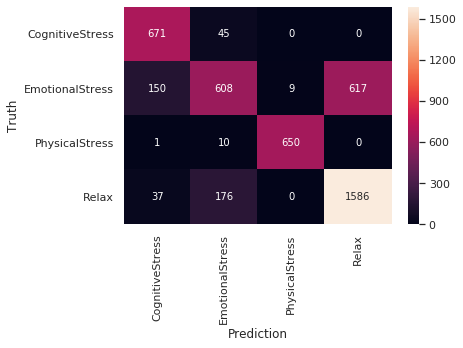

In [251]:
pred_nb = nb.predict(X_test)
print(classification_report(y_test, pred_nb, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

### Random Forest Classifier

A Naive Bayes model doesn't really support tuning.  Let's try an ensemble algorithm such as Random Forest.

This creates a number of decision tree classifiers on subsets of the dataset, and averages the results.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [252]:
# max_depth and n_estimators limit overfitting
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

rf.fit(X_train, y_train)
rf.score(X_test, y_test)

print('Accuracy', rf.score(X_test, y_test))

Accuracy 0.9462719298245614


                 precision    recall  f1-score   support

CognitiveStress       0.85      0.98      0.91       716
EmotionalStress       0.93      0.91      0.92      1384
 PhysicalStress       0.99      0.99      0.99       661
          Relax       0.99      0.94      0.96      1799

       accuracy                           0.95      4560
      macro avg       0.94      0.96      0.95      4560
   weighted avg       0.95      0.95      0.95      4560



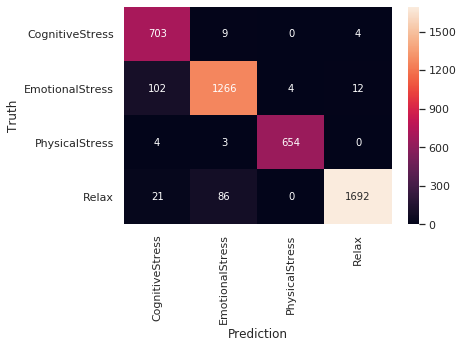

In [253]:
pred_rf = rf.predict(X_test)
print(classification_report(y_test, pred_rf, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_rf), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

### Tuning

We can perform a grid search both kBest and on combinations of RandomForest hyperparameters to find a better model.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [0]:
# Earlier we used k=5 for kBest, now we can actually tune it while
# training the model
pipeline = Pipeline(steps=[
  ('kbest', SelectKBest()),
  ('rf', RandomForestClassifier())
])

# setup the parameter grid to search
# the format is: stepname__parameter
param_grid = {
    'kbest__k' : [3, 5, 7],
    'rf__max_depth': [5, 7, 9, 11, 13],
    'rf__n_estimators': [75, 100, 125, 150, 175, 200]
}

X_train_before_kbest = df_train.loc[:, candidate_features]
X_test_before_kbest = df_test.loc[:, candidate_features]

# Run 4 jobs concurrently, using cross validation split of 3
gs = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=3, verbose=True, 
                  return_train_score=True)
gs.fit(X_train_before_kbest, y_train)
print('Accuracy', gs.score(X_test_before_kbest, y_test))
print('Best combination', gs.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [0]:
pd.DataFrame(gs.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.136125,0.000000,0.015617,0.000000e+00,3,75,"{'max_depth': 3, 'n_estimators': 75}",0.908134,0.908313,0.912481,0.909643,0.002008,43,0.908752,0.912610,0.909430,0.910264,0.001682
1,0.184741,0.001243,0.025760,7.570860e-03,3,100,"{'max_depth': 3, 'n_estimators': 100}",0.908353,0.906339,0.912700,0.909131,0.002654,44,0.908862,0.911294,0.909978,0.910045,0.000994
2,0.220268,0.009394,0.031253,1.388343e-05,3,125,"{'max_depth': 3, 'n_estimators': 125}",0.908353,0.905462,0.909849,0.907888,0.001821,49,0.909300,0.910197,0.907018,0.908838,0.001339
3,0.255734,0.008081,0.030742,6.865574e-04,3,150,"{'max_depth': 3, 'n_estimators': 150}",0.908353,0.905681,0.909849,0.907961,0.001724,48,0.909300,0.909978,0.906908,0.908729,0.001317
4,0.344232,0.012266,0.043816,3.450327e-03,3,175,"{'max_depth': 3, 'n_estimators': 175}",0.908353,0.906558,0.909849,0.908254,0.001345,46,0.909410,0.910417,0.906908,0.908912,0.001475
5,0.404429,0.031635,0.062730,1.343571e-03,3,200,"{'max_depth': 3, 'n_estimators': 200}",0.908353,0.906778,0.910726,0.908619,0.001623,45,0.909300,0.910088,0.907346,0.908911,0.001152
6,0.457935,0.020594,0.057843,9.876300e-03,3,225,"{'max_depth': 3, 'n_estimators': 225}",0.908353,0.906558,0.909849,0.908254,0.001345,46,0.909300,0.910197,0.906798,0.908765,0.001438
7,0.174554,0.007757,0.019835,3.088468e-03,5,75,"{'max_depth': 5, 'n_estimators': 75}",0.941022,0.940996,0.950647,0.944221,0.004543,38,0.945821,0.947149,0.945504,0.946158,0.000712
8,0.239431,0.018461,0.029403,2.621668e-03,5,100,"{'max_depth': 5, 'n_estimators': 100}",0.941460,0.941215,0.954157,0.945610,0.006043,36,0.945821,0.947368,0.949232,0.947474,0.001395
9,0.264728,0.006678,0.036450,7.364516e-03,5,125,"{'max_depth': 5, 'n_estimators': 125}",0.940802,0.941435,0.953937,0.945391,0.006048,37,0.945273,0.947149,0.950000,0.947474,0.001943


                 precision    recall  f1-score   support

CognitiveStress       0.98      0.98      0.98       716
EmotionalStress       0.98      0.99      0.99      1384
 PhysicalStress       1.00      1.00      1.00       661
          Relax       1.00      0.99      0.99      1799

      micro avg       0.99      0.99      0.99      4560
      macro avg       0.99      0.99      0.99      4560
   weighted avg       0.99      0.99      0.99      4560



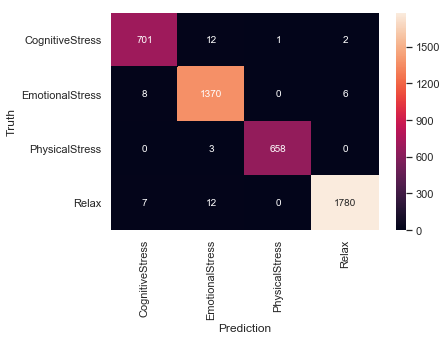

In [0]:
pred_gs = gs.predict(X_test)
print(classification_report(y_test, pred_gs, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_gs), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

## Train using frequency domain features

If time domain features aren't performing well (not really the case here), we can also try using the FFT to fit the model.

1. Take rolling windows of the signal
2. Compute spectral features based on the FFT
3. Use both original and spectral features in our model

To learn, we'll be computing the spectral features "by hand", but you can alternatively consider a package like tsfresh that calculates and evaluates the features automatically:
* https://tsfresh.readthedocs.io/en/latest/text/introduction.html
* https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html#tsfresh.feature_extraction.feature_calculators.fft_aggregated


In [0]:
def compute_fft(df, window_size=1, samples_per_sec=8, smoothing=False):
    if smoothing:
        df_ = df.rolling(m, win_type='hamming').mean().dropna()
    else:
        df_ = df
    
    sample_freq_ = fftpack.fftfreq(len(df_), d=1./samples_per_sec)
    pos_mask_ = sample_freq_ > 0
    
    result_df_ = pd.DataFrame(index = sample_freq_[pos_mask_])
    
    # FFT needs to be computed per column, hence we are using a loop
    for c in df_.columns:
        if df_[c].dtype == float:
            fft_ = np.abs(fftpack.fft(df_[c])) # take the magnitude
            result_df_[c + '_fft'] = fft_[pos_mask_]
    
    return result_df_

Since FFT is in the frequency domain, we will need to break up the time signal into time-windows.

Let's say we have time windows of 10 seconds, and we extract FFT characteristics from it.

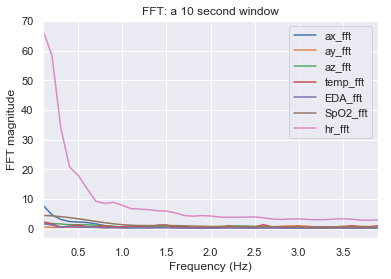

In [0]:
time_window_sec = 10
start_index = 0
end_index = time_window_sec * samples_per_sec

df_time_window = df.iloc[start_index:end_index]
fft_time_window = compute_fft(df_time_window)

fig, ax = plt.subplots()
fft_time_window.plot(ax=ax) # plotting this way adds the correct labels

ax.set_title(f'FFT: a {time_window_sec} second window')
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('FFT magnitude')
plt.show()

In [0]:
fft_time_window.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 39 entries, 0.1 to 3.9000000000000004
Data columns (total 7 columns):
ax_fft      39 non-null float64
ay_fft      39 non-null float64
az_fft      39 non-null float64
temp_fft    39 non-null float64
EDA_fft     39 non-null float64
SpO2_fft    39 non-null float64
hr_fft      39 non-null float64
dtypes: float64(7)
memory usage: 2.4 KB


In [0]:
fft_time_window.max()

ax_fft       7.829464
ay_fft       0.927551
az_fft       1.704144
temp_fft     2.296426
EDA_fft      1.778630
SpO2_fft     4.446346
hr_fft      66.718185
dtype: float64

In [0]:
fft_time_window.min()

ax_fft      0.064002
ay_fft      0.055378
az_fft      0.157182
temp_fft    0.200049
EDA_fft     0.077439
SpO2_fft    0.507413
hr_fft      2.806981
dtype: float64

#### Spectral Centroid

This corresponds to the balancing point or the center of mass of the spectral power distribution.
This value is calculated as the weighted mean of the frequency components present in the signal:

$$\frac{\sum{F(n) \times n}}{\sum F(n)}$$

In [0]:
# Spectral centroid is the weighted mean of the frequency components
# fft_time_window.index are the frequencies
spectral_centroid = np.dot(fft_time_window.index, fft_time_window) / np.sum(fft_time_window)

#### Spectral Energy

The equivalent to the energy of the signal as discussed before in
the frequency domain is the spectral energy. This value is computed as the sum of
the squares of the magnitude of the frequency content:

$$\sum{F(n)^2}$$

In [0]:
# Spectral energy

np.sum(fft_time_window ** 2) # sum of squares

ax_fft        117.230099
ay_fft         13.465233
az_fft         24.141792
temp_fft       26.034523
EDA_fft         6.846713
SpO2_fft      117.253578
hr_fft      10765.328534
dtype: float64

#### Spectral Entropy

This refers to the entropy of the signal in the frequency domain. The frequency content of the signal is normalized before the entropy computation.

$$-\sum{\hat{F}(n) \times log(\hat{F}(n))} $$

In [0]:
# normalise the FFT
normalized_fft_time_window = fft_time_window / np.sum(fft_time_window)

# compute entropy
-np.sum(normalized_fft_time_window * np.log(normalized_fft_time_window))

ax_fft      3.025439
ay_fft      3.583320
az_fft      3.492103
temp_fft    3.526712
EDA_fft     3.270150
SpO2_fft    3.361024
hr_fft      3.055795
dtype: float64

### Computing Spectal Features

We'll wrap the computation into a function and then call that function using the pd.DataFrame.rolling() method.

In [0]:
def compute_fft(df, window_size=1, samples_per_sec=8, smoothing=False):
    if smoothing:
        df_ = df.rolling(m, win_type='hamming').mean().dropna()
    else:
        df_ = df
    
    sample_freq_ = fftpack.fftfreq(len(df_), d=1./samples_per_sec)
    pos_mask_ = sample_freq_ > 0
    
    fft_ = np.abs(fftpack.fft(df_))
    result_df_ = pd.Series(index=sample_freq_[pos_mask_], data=fft_[pos_mask_])
    return result_df_

def spectral_centroid(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    return np.dot(fft_.index, fft_) / np.sum(fft_)

def spectral_energy(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    return np.sum(fft_ ** 2)

def spectral_entropy(df):
    fft_ = compute_fft(df, window_size=1, samples_per_sec=samples_per_sec, smoothing=False)
    normalized_fft_ = fft_ / np.sum(fft_)
    return -np.sum(normalized_fft_ * np.log(normalized_fft_))

# Example usage:
window_size_secs = 10

# raw = False applies to a pandas Series
# df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_centroid, raw=False).dropna().head(10)
# df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_energy, raw=False).dropna().head(10)
df['ay'].rolling(window_size_secs * samples_per_sec).apply(spectral_entropy, raw=False).dropna().head(10)

2019-01-01 00:00:09.875    3.583320
2019-01-01 00:00:10.000    3.583374
2019-01-01 00:00:10.125    3.582478
2019-01-01 00:00:10.250    3.582808
2019-01-01 00:00:10.375    3.582808
2019-01-01 00:00:10.500    3.582572
2019-01-01 00:00:10.625    3.582423
2019-01-01 00:00:10.750    3.582423
2019-01-01 00:00:10.875    3.582603
2019-01-01 00:00:11.000    3.582603
Freq: 125L, Name: ay, dtype: float64

In [0]:
float_columns = ['ax', 'ay', 'az', 'temp', 'EDA', 'SpO2', 'hr']

# This can take a while to run... because we do an FFT per column, 3 times
# While groupby supports multiple functions, groupby does not do rolling windows, 
# so we have to call rolling 3 times
for f in float_columns:
    df[f + '_sc'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_centroid, raw=False)
    df[f + '_sen'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_energy, raw=False)
    df[f + '_se'] = df[f].rolling(window_size_secs * samples_per_sec).apply(spectral_entropy, raw=False)

df.dropna(inplace=True)
df.head(10)

,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,az_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
2019-01-01 00:00:09.875,0.499988,-1.009969,0.000000,27.400056,3.455063,95.999939,90.124819,3,1,6,...,3.526712,1.182509,6.846713,3.270150,1.204175,1.172536e+02,3.361024,0.964893,10765.328534,3.055795
2019-01-01 00:00:10.000,0.439993,-0.989967,0.009957,27.400056,3.461001,95.999939,89.999817,2,1,7,...,3.545186,1.126998,7.478393,3.239428,1.235085,8.125248e+01,3.389658,0.958255,11821.360762,3.038428
2019-01-01 00:00:10.125,0.430017,-0.989967,0.019958,27.400056,3.461001,95.999939,89.874815,2,1,7,...,3.523494,1.090045,8.056895,3.217817,1.276738,5.336100e+01,3.423469,0.952810,12892.502826,3.019548
2019-01-01 00:00:10.250,0.420006,-0.999985,0.000000,27.400056,3.461001,95.999939,89.749813,2,1,6,...,3.516658,1.096740,8.629681,3.214002,1.326084,3.254787e+01,3.459742,0.949303,13978.473467,3.001510
2019-01-01 00:00:10.375,0.459979,-1.009969,0.000000,27.400056,3.461001,95.999939,89.624811,2,1,6,...,3.521607,1.053712,9.124176,3.171730,1.395763,1.793805e+01,3.503496,0.944879,15077.397629,2.984480
2019-01-01 00:00:10.500,0.439993,-0.999985,0.019958,27.400056,3.461001,95.999939,89.499809,2,1,7,...,3.545663,1.060983,9.612955,3.170191,1.492274,8.437758e+00,3.551373,0.939871,16188.931551,2.973646
2019-01-01 00:00:10.625,0.449968,-0.989967,0.000000,27.400056,3.461001,95.999939,89.374807,2,1,6,...,3.534355,1.022957,10.023442,3.137594,1.644942,3.046968e+00,3.609534,0.932730,17311.075171,2.967367
2019-01-01 00:00:10.750,0.479966,-0.999985,0.029958,27.400056,3.461001,95.999939,89.249805,2,1,7,...,3.456899,1.067783,10.428213,3.156510,2.000000,6.093936e-01,3.663562,0.926109,18443.422228,2.961630
2019-01-01 00:00:10.875,0.459979,-1.019987,0.009957,27.400056,3.461001,95.999939,89.124804,2,0,7,...,3.451079,1.026728,10.719342,3.105919,0.938923,2.584939e-25,2.829344,0.916323,19583.847656,2.956597
2019-01-01 00:00:11.000,0.459979,-1.009969,0.009957,27.400056,3.461001,95.999939,88.999802,2,1,7,...,3.452934,1.056626,11.040105,3.102408,0.938923,2.584939e-25,2.829344,0.919883,20731.882692,2.962953


In [0]:
# move the label column to the front so that it is easy to see
new_cols = ['label', 'label_enc'] + df.columns.drop(['label', 'label_enc']).tolist()

df = df[new_cols]
df.head()

,label,label_enc,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
2019-01-01 00:00:09.875,Relax,3,0.499988,-1.009969,0.000000,27.400056,3.455063,95.999939,90.124819,3,...,3.526712,1.182509,6.846713,3.270150,1.204175,117.253578,3.361024,0.964893,10765.328534,3.055795
2019-01-01 00:00:10.000,Relax,3,0.439993,-0.989967,0.009957,27.400056,3.461001,95.999939,89.999817,2,...,3.545186,1.126998,7.478393,3.239428,1.235085,81.252480,3.389658,0.958255,11821.360762,3.038428
2019-01-01 00:00:10.125,Relax,3,0.430017,-0.989967,0.019958,27.400056,3.461001,95.999939,89.874815,2,...,3.523494,1.090045,8.056895,3.217817,1.276738,53.361003,3.423469,0.952810,12892.502826,3.019548
2019-01-01 00:00:10.250,Relax,3,0.420006,-0.999985,0.000000,27.400056,3.461001,95.999939,89.749813,2,...,3.516658,1.096740,8.629681,3.214002,1.326084,32.547868,3.459742,0.949303,13978.473467,3.001510
2019-01-01 00:00:10.375,Relax,3,0.459979,-1.009969,0.000000,27.400056,3.461001,95.999939,89.624811,2,...,3.521607,1.053712,9.124176,3.171730,1.395763,17.938047,3.503496,0.944879,15077.397629,2.984480


In [0]:
df.corr()

,label_enc,ax,ay,az,temp,EDA,SpO2,hr,ax_q10,ay_q10,...,temp_se,EDA_sc,EDA_sen,EDA_se,SpO2_sc,SpO2_sen,SpO2_se,hr_sc,hr_sen,hr_se
label_enc,1.000000,0.628024,0.416908,-0.212998,-0.552135,-0.442576,-0.575869,-0.028444,0.670244,0.367554,...,0.131894,-0.078281,0.061790,-0.096468,0.217540,-0.116965,-0.107780,-0.018001,-0.049490,-0.020780
ax,0.628024,1.000000,0.358835,0.163231,-0.147382,-0.189890,-0.322946,-0.455915,0.951561,0.287757,...,0.120904,0.366896,-0.041924,0.336556,0.186594,-0.231304,-0.123070,-0.100780,-0.009543,-0.069203
ay,0.416908,0.358835,1.000000,0.139095,-0.110311,-0.288748,-0.494076,-0.041851,0.380750,0.978238,...,0.159688,-0.038040,-0.042286,-0.065917,0.133115,-0.086540,-0.018044,0.039485,0.050013,0.044260
az,-0.212998,0.163231,0.139095,1.000000,0.252783,0.329102,0.179592,-0.607334,0.153782,0.129964,...,0.020761,0.536328,-0.064561,0.518829,-0.042520,-0.155963,-0.026344,-0.129791,-0.105418,-0.060268
temp,-0.552135,-0.147382,-0.110311,0.252783,1.000000,0.735738,0.290640,-0.278047,-0.191014,-0.112021,...,0.061446,0.366810,-0.026100,0.320406,-0.089977,0.040837,0.193373,-0.031991,0.010328,-0.013690
EDA,-0.442576,-0.189890,-0.288748,0.329102,0.735738,1.000000,0.395421,-0.221993,-0.145512,-0.258785,...,0.052635,0.356759,0.052425,0.356086,-0.116030,0.068263,0.085592,-0.092801,0.021686,-0.054348
SpO2,-0.575869,-0.322946,-0.494076,0.179592,0.290640,0.395421,1.000000,0.002626,-0.352680,-0.461340,...,-0.047364,0.123414,-0.010722,0.122720,-0.200426,0.206514,0.107258,-0.044399,0.205611,-0.023590
hr,-0.028444,-0.455915,-0.041851,-0.607334,-0.278047,-0.221993,0.002626,1.000000,-0.407496,0.012378,...,-0.017117,-0.638870,0.216835,-0.588999,-0.010537,0.251194,0.029364,0.178937,0.200085,0.099797
ax_q10,0.670244,0.951561,0.380750,0.153782,-0.191014,-0.145512,-0.352680,-0.407496,1.000000,0.324717,...,0.108054,0.374033,-0.042376,0.354821,0.213466,-0.260806,-0.152107,-0.104229,-0.005868,-0.071208
ay_q10,0.367554,0.287757,0.978238,0.129964,-0.112021,-0.258785,-0.461340,0.012378,0.324717,1.000000,...,0.152429,-0.070209,-0.038529,-0.091708,0.133673,-0.073526,-0.020450,0.045275,0.049111,0.047305


### K-best Feature selection

In [0]:
df_train, df_test = train_test_split(df, random_state=42)

X_train = df_train[df.columns.drop(['label', 'label_enc'])]
X_test = df_test[df.columns.drop(['label', 'label_enc'])]

y_train = df_train['label_enc']
y_test = df_test['label_enc']

kbest = SelectKBest(k=8, score_func=f_classif)
kbest.fit(X_train, y_train)

X_train.columns[kbest.get_support()]

Index(['ax', 'az', 'temp', 'SpO2', 'hr', 'ax_q10', 'EDA_sc', 'EDA_se'], dtype='object')

In [0]:
# drop ax_q10 since it is derived from ax (collinear features are problematic for convergence of some algorithms)

X_train = df_train[df.columns.drop(['label', 'label_enc', 'ax_q10', 'ay_q10', 'az_q10'])]
X_test = df_test[df.columns.drop(['label', 'label_enc', 'ax_q10', 'ay_q10', 'az_q10'])]

y_train = df_train['label_enc']
y_test = df_test['label_enc']

### Retrain Model

In [0]:
nb = GaussianNB()
nb.fit(X_train, y_train)
nb.score(X_test, y_test)

0.8120067643742954

                 precision    recall  f1-score   support

CognitiveStress       0.71      0.93      0.80       647
EmotionalStress       0.87      0.71      0.78      1219
 PhysicalStress       0.94      0.97      0.95       430
          Relax       0.79      0.80      0.79      1252

      micro avg       0.81      0.81      0.81      3548
      macro avg       0.83      0.85      0.83      3548
   weighted avg       0.82      0.81      0.81      3548



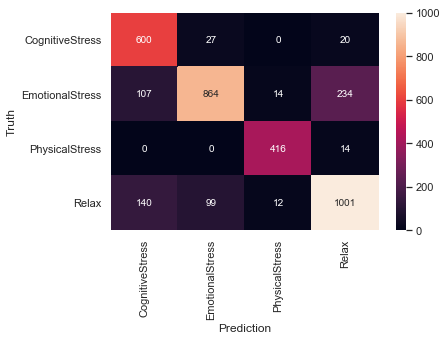

In [0]:
pred_nb = nb.predict(X_test)
print(classification_report(y_test, pred_nb, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_nb), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

The Naive Bayes classifier performed slightly better overall with spectral features.

Inclusion of spectral features reduced the ability of the classifier to distinguish "Relax" and "EmotionalStress". It mistakenly predicted more cases of "Relax" as "EmotionalStress" (0.36 recall, with 219 errors). 

Without spectral features:
```
                 precision    recall  f1-score   support

CognitiveStress       0.78      0.94      0.85       716
EmotionalStress       0.72      0.44      0.55      1384
 PhysicalStress       0.99      0.98      0.98       661
          Relax       0.72      0.88      0.79      1799

      micro avg       0.77      0.77      0.77      4560
      macro avg       0.80      0.81      0.79      4560
   weighted avg       0.77      0.77      0.76      4560
```

With spectral features (FFT window length 10s):
```
                 precision    recall  f1-score   support

CognitiveStress       0.75      0.92      0.82       641
EmotionalStress       0.78      0.87      0.82      1020
 PhysicalStress       0.90      0.95      0.92       315
          Relax       0.90      0.36      0.51       479

      micro avg       0.79      0.79      0.79      2455
      macro avg       0.83      0.77      0.77      2455
   weighted avg       0.81      0.79      0.77      2455

```

In [0]:
param_grid = {
    'max_depth': [3, 5, 7, 9, 11, 13, 15],
    'n_estimators': [75, 100, 125, 150, 175, 200, 225]
}

# Run 4 jobs concurrently
gs = GridSearchCV(rf, param_grid, n_jobs=4, cv=3, verbose=True, return_train_score=True)
gs.fit(X_train, y_train)
print('Accuracy', gs.score(X_test, y_test))
print('Best combination', gs.best_params_)

Fitting 3 folds for each of 49 candidates, totalling 147 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=4)]: Done 147 out of 147 | elapsed:   48.2s finished


Accuracy 0.9988726042841037
Best combination {'max_depth': 11, 'n_estimators': 100}


                 precision    recall  f1-score   support

CognitiveStress       1.00      1.00      1.00       647
EmotionalStress       1.00      1.00      1.00      1219
 PhysicalStress       1.00      1.00      1.00       430
          Relax       1.00      1.00      1.00      1252

      micro avg       1.00      1.00      1.00      3548
      macro avg       1.00      1.00      1.00      3548
   weighted avg       1.00      1.00      1.00      3548



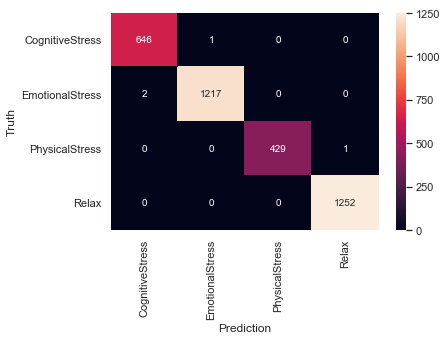

In [0]:
pred_gs = gs.predict(X_test)
print(classification_report(y_test, pred_gs, target_names=le.classes_))

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, pred_gs), annot=True, fmt='d',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=ax)
ax.set_xlabel('Prediction')
ax.set_ylabel('Truth')
plt.show()

The RandomForest classifier performed almost perfectly with Spectral Features.  It was able to use the additional spectral features to correctly identify all but 3 cases.  It had no trouble distinguishing between the "Relax" and "EmotionalStress" categories, for example.

Without spectral features:
```
                 precision    recall  f1-score   support

CognitiveStress       0.98      0.98      0.98       716
EmotionalStress       0.98      0.99      0.99      1384
 PhysicalStress       1.00      1.00      1.00       661
          Relax       1.00      0.99      0.99      1799

      micro avg       0.99      0.99      0.99      4560
      macro avg       0.99      0.99      0.99      4560
   weighted avg       0.99      0.99      0.99      4560
```

With spectral features (FFT window length 10s):
```
                 precision    recall  f1-score   support

CognitiveStress       1.00      1.00      1.00       641
EmotionalStress       1.00      1.00      1.00      1020
 PhysicalStress       1.00      1.00      1.00       315
          Relax       1.00      1.00      1.00       479

      micro avg       1.00      1.00      1.00      2455
      macro avg       1.00      1.00      1.00      2455
   weighted avg       1.00      1.00      1.00      2455
```

## Decision Boundaries

(You can never be done with analysis).

Let's see if we can compare the decision boundaries, to get a better sense of how the features are spread out.

1. Perform 2-D PCA so that we can visualise all the features in a 2-D plot
2. Create a mesh grid, colour regions based on predictions from the classifier
3. Repeat step 2 for each classifier

In [0]:
# PCA presumes zero centered mean, so we scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)

Z_train_pca = pca.fit_transform(X_train_scaled)
Z_test_pca = pca.transform(X_test_scaled)

# Train and test sets are shuffled by train_test_split before the split,
# so we need to concatenate instead of using X and y.
# Also, we want to use the scaled version of X
Z_pca = np.concatenate((Z_train_pca, Z_test_pca), axis=0)
y_all = np.concatenate((y_train, y_test), axis=0)

### Plot data points

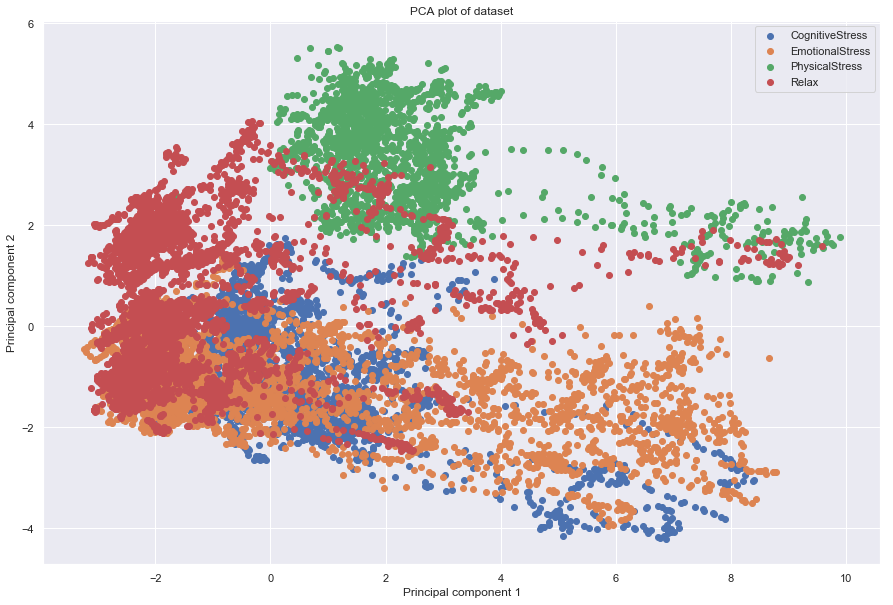

In [0]:
fig, ax = plt.subplots(figsize=(15, 10))

for i in range(0, len(le.classes_)):
    # y_train == i filters a subset of rows where y_train is i    
    # The ..., 0] refers to the first principal component
    # The ..., 1] refers to the second principal component
    ax.scatter(Z_pca[y_all == i, 0], Z_pca[y_all == i, 1], label=le.classes_[i])
ax.legend()

ax.set_title('PCA plot of dataset')
ax.set_xlabel('Principal component 1')
ax.set_ylabel('Principal component 2')
plt.show()

### Plot decision boundaries

In [0]:
def plot_decision_boundaries(ax, title, clf, data, target, step_size=.02):
    """Plots the decision boundaries for a fitted classifier model
    Args:
        ax: subplot axis
        title: subplot title
        clf: a fitted sklearn classification model
        data: 2-dimensional input data
        target: the target truth values (y)
        step_size: Step size of the mesh. Decrease to increase the quality of the plot.
        
    Globals:
        pca: fitted PCA transformer for projecting 2-dimensional to original X dimension
        scaler: fitted StandardScaler for unscaling the X back to original scale
        le: fitted LabelEncoder for mapping to class labels

    Based on: http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    """
    # Generate a mesh of many points, this will become regions when coloured
    x_min_, x_max_ = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min_, y_max_ = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx_, yy_ = np.meshgrid(np.arange(x_min_, x_max_, step_size), np.arange(y_min_, y_max_, step_size))

    # Make 2 columns (principal component 1, principal component 2)
    zz_ = np.c_[xx_.ravel(), yy_.ravel()]
    
    # We need to inverse both PCA and scaling because clf is trained on unscaled and un-PCA'ed data
    z_ = pca.inverse_transform(zz_) # inverse-PCA
    z_ = scaler.inverse_transform(z_) # unscale
    
    # Obtain labels for each point in mesh using the trained model
    pred_ = clf.predict(z_)

    # Put the result into a color plot
    pred_ = pred_.reshape(xx_.shape)

    # Plot the decision boundary. Assign a colour based on prediction
    ax.imshow(pred_, interpolation='nearest',
              extent=(xx_.min(), xx_.max(), yy_.min(), yy_.max()),
              cmap=plt.cm.Pastel2,
              aspect='auto', origin='lower')

    # Plot the points. Assign a colour based on truth
    # Made the points smaller and more transparent so that the boundaries are still visible.
    for i in range(0, len(le.classes_)):
        ax.scatter(data[target == i, 0], data[target == i, 1], label=le.classes_[i],
                   alpha=.6)

    ax.set(title=title, xlim=(x_min_, x_max_), ylim=(y_min_, y_max_),
           xlabel='Principal component 1', ylabel='Principal component 2')
    ax.legend()

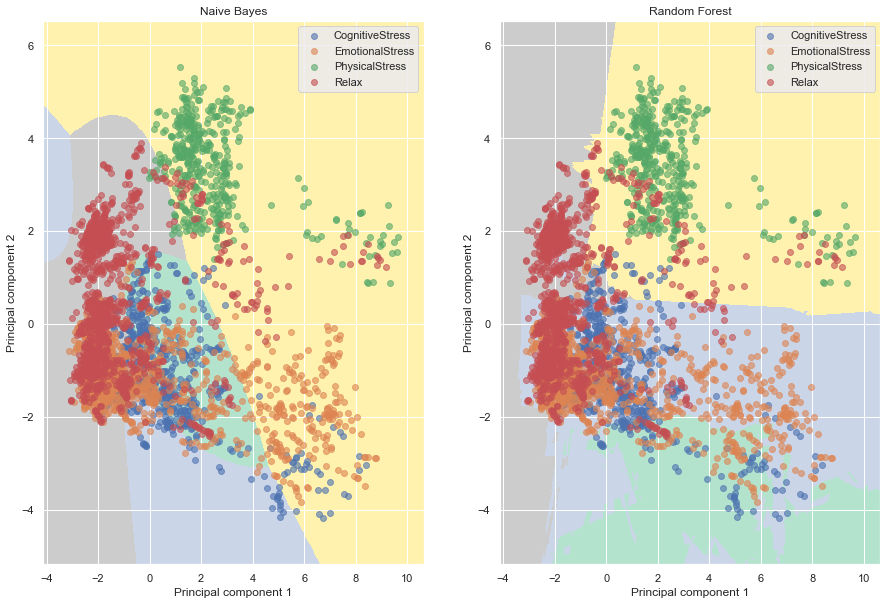

In [0]:
# Just plot the test set to speed things up
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 10))
plot_decision_boundaries(ax1, 'Naive Bayes', nb, Z_test_pca, y_test)
plot_decision_boundaries(ax2, 'Random Forest', gs, Z_test_pca, y_test)
plt.show()

Naive Bayes is a simple model, and its gaussian-shaped boundaries are not complex enough to separate the different classes

Random Forest generates more complex boundaries, you can see the irregularly shaped boundaries.

Note: The boundaries are also projected in 2-D, so it looks like there are more mistakes here, but each actual boundary is N dimension.